# Question and Answers

This example shows how to use deep RNN to create model to work on a question-answer-system based on episodic memory.


References: 
- http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz 
- https://research.fb.com/downloads/babi/

In [32]:
from __future__ import division, print_function
import collections
import itertools
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [33]:
def get_data(infile):
    stories, questions, answers = [], [], []
    story_text = []
    
    with open(infile) as f:
        for line in f:
            line = line.strip()
            lno, text = line.split(' ', 1)
            if '\t' in text:
                question, answer, _ = text.split('\t')
                stories.append(story_text)
                questions.append(question)
                answers.append(answer)
                story_text = []
            else:
                story_text.append(text)
                
    return stories, questions, answers

In [100]:
data_train = get_data('./tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_train.txt')
data_test = get_data('./tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_test.txt')

In [35]:
print('Train observations:', len(data_train[0]))
print('Test observations:', len(data_test[0]))

Train observations: 10000
Test observations: 1000


In [93]:
# Building vocab dictionary from train and test data.
dictionary = collections.Counter()

for stories, questions, answers in [data_train, data_test]:
    for story in stories:
        for sent in story:
            for word in nltk.word_tokenize(sent):
                dictionary[word.lower()] += 1
    
    for question in questions:
        for word in nltk.word_tokenize(question):
            dictionary[word.lower()] += 1
    
    for answer in answers:
        for word in nltk.word_tokenize(answer):
            dictionary[word.lower()] += 1

In [37]:
word2idx = {w: (i+1) for i, (w, _) in enumerate(dictionary.most_common())}
word2idx['PAD'] = 0
idx2word = {v:k for k, v in word2idx.items()}

In [121]:
vocab_size = len(word2idx)
vocab_size

22

In [142]:
# Compute max sequence length for each entity.
story_maxlen = 0
question_maxlen = 0

for stories, questions, answers in [data_train, data_test]:
    for story in stories:
        story_len = 0

        for sent in story:
            swords = nltk.word_tokenize(sent)
            story_len += len(swords)

        if story_len > story_maxlen:
            story_maxlen = story_len

    for question in questions:

        question_len = len(nltk.word_tokenize(question))
        if question_len > question_maxlen:
            question_maxlen = question_len

print('Story maximum length: {}, question maximum length: {}'.format(story_maxlen, question_maxlen))

Story maximum length: 14, question maximum length: 4


In [143]:
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, Permute
from keras.layers.embeddings import Embedding
from keras.layers.merge import add, concatenate, dot
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

In [145]:
# Converting data into vectorized form.
def data_vectorization(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    stories, questions, answers = data
    
    for story, question, answer in zip(stories, questions, answers):
        xs = [[word2idx[w.lower()] for w in nltk.word_tokenize(s)] 
             for s in story]
        xs = list(itertools.chain.from_iterable(xs))
        
        xq = [word2idx[w.lower()] for w in nltk.word_tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer.lower()])
    
    return pad_sequences(Xs, maxlen=story_maxlen), \
           pad_sequences(Xq, maxlen=question_maxlen), \
           np_utils.to_categorical(Y, num_classes=len(word2idx))

In [146]:
Xstrain, Xqtrain, Ytrain = data_vectorization(data_train, word2idx, story_maxlen, question_maxlen)
Xstest, Xqtest, Ytest = data_vectorization(data_test, word2idx, story_maxlen, question_maxlen)

print('Train story:', Xstrain.shape)
print('Train question:', Xqtrain.shape)
print('Train answer:', Ytrain.shape)

print('Test story:', Xstest.shape)
print('Test question:', Xqtest.shape)
print('Test answer:', Ytest.shape)

Train story: (10000, 14)
Train question: (10000, 4)
Train answer: (10000, 22)
Test story: (1000, 14)
Test question: (1000, 4)
Test answer: (1000, 22)


In [147]:
# Model parameters.
EMBEDDING_SIZE = 128
LATENT_SIZE = 64
BATCH_SIZE = 64
NUM_EPOCHS = 40

In [148]:
# Inputs.
story_input = Input(shape=(story_maxlen,))
question_input = Input(shape=(question_maxlen,))

In [149]:
# Story encoder embedding.
story_encoder = Embedding(input_dim=vocab_size,
                         output_dim=EMBEDDING_SIZE,
                         input_length=story_maxlen)(story_input)
story_encoder = Dropout(0.2)(story_encoder)

In [150]:
# Question encoder embedding.
question_encoder = Embedding(input_dim=vocab_size,
                            output_dim=EMBEDDING_SIZE,
                            input_length=question_maxlen)(question_input)
question_encoder = Dropout(0.3)(question_encoder)

In [151]:
# Match between story and question.
match = dot([story_encoder, question_encoder], axes=[2, 2])

In [152]:
# Encode story into vector space of question.
story_encoder_c = Embedding(input_dim=vocab_size, 
                            output_dim=question_maxlen, 
                            input_length=story_maxlen)(story_input)
story_encoder_c = Dropout(0.3)(story_encoder_c)

In [153]:
# Combine match and story vectors.
response = add([match, story_encoder_c])
response = Permute((2, 1))(response)

In [154]:
# Combine response and question vectors to answers space.
answer = concatenate([response, question_encoder], axis=-1)
answer = LSTM(LATENT_SIZE)(answer)
answer = Dropout(0.2)(answer)
answer = Dense(vocab_size)(answer)

output = Activation('softmax')(answer)

model = Model(inputs=[story_input, question_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 14, 128)      2816        input_9[0][0]                    
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 4, 128)       2816        input_10[0][0]                   
______________________________________________________________________________________

In [155]:
Xstrain = np.array(Xstrain)
Xqtrain = np.array(Xqtrain)
Ytrain = np.array(Ytrain)
# Model training.
history = model.fit((Xstrain, Xqtrain), Ytrain,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=((Xstest, Xqtest), Ytest))

Epoch 1/40
157/157 [==============================] - 2s 15ms/step - loss: 2.0418 - accuracy: 0.1701 - val_loss: 1.7559 - val_accuracy: 0.2750
Epoch 2/40
157/157 [==============================] - 2s 10ms/step - loss: 1.6886 - accuracy: 0.2887 - val_loss: 1.6568 - val_accuracy: 0.3480
Epoch 3/40
157/157 [==============================] - 1s 8ms/step - loss: 1.5580 - accuracy: 0.4067 - val_loss: 1.4784 - val_accuracy: 0.4970
Epoch 4/40
157/157 [==============================] - 1s 8ms/step - loss: 1.4243 - accuracy: 0.4959 - val_loss: 1.3877 - val_accuracy: 0.5190
Epoch 5/40
157/157 [==============================] - 1s 9ms/step - loss: 1.3484 - accuracy: 0.5193 - val_loss: 1.3189 - val_accuracy: 0.5300
Epoch 6/40
157/157 [==============================] - 1s 8ms/step - loss: 1.2896 - accuracy: 0.5246 - val_loss: 1.2803 - val_accuracy: 0.5400
Epoch 7/40
157/157 [==============================] - 1s 9ms/step - loss: 1.2432 - accuracy: 0.5401 - val_loss: 1.2222 - val_accuracy: 0.5670
Epoc

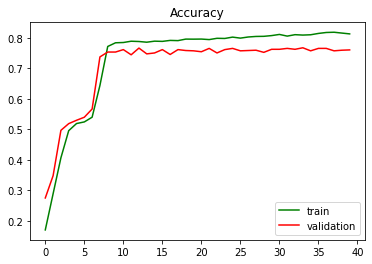

In [156]:
# Plot accuracy and loss plot.
plt.title('Accuracy')
plt.plot(history.history['accuracy'], color='g', label='train')
plt.plot(history.history['val_accuracy'], color='r', label='validation')
plt.legend(loc='best')
plt.show()

In [157]:
# Get predictions of labels.
ytest = np.argmax(Ytest, axis=1)
Ytest_pred = model.predict([Xstest, Xqtest])

In [158]:
ytest_pred = np.argmax(Ytest_pred, axis=1)

In [159]:
# Select random questions and predict answers.
NUM_DISPLAY = 10

In [161]:
for i in random.sample(range(Xstest.shape[0]), NUM_DISPLAY):
    story = ' '.join([idx2word[x] for x in Xstest[i].tolist() if x != 0])
    question = ' '.join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_pred[i]]
    print('Story:', story)
    print('Question:', question)
    print('Label:', label)
    print('Prediction:', prediction)
    print()

Story: mary moved to the bathroom . mary travelled to the office .
Question: where is mary ?
Label: office
Prediction: office

Story: john journeyed to the garden . john journeyed to the office .
Question: where is john ?
Label: office
Prediction: office

Story: john moved to the bathroom . sandra travelled to the kitchen .
Question: where is sandra ?
Label: kitchen
Prediction: kitchen

Story: john moved to the bedroom . mary travelled to the bathroom .
Question: where is mary ?
Label: bathroom
Prediction: bathroom

Story: sandra journeyed to the office . daniel went back to the hallway .
Question: where is daniel ?
Label: hallway
Prediction: hallway

Story: mary went to the bathroom . john went to the bathroom .
Question: where is mary ?
Label: bathroom
Prediction: bathroom

Story: sandra went to the office . sandra travelled to the bathroom .
Question: where is sandra ?
Label: bathroom
Prediction: bathroom

Story: john journeyed to the bedroom . daniel went back to the kitchen .
Ques